In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# We define any function, using mathematical terms to better understand the underlyings
def f(x):
    return x**2 - 4*x 

# Return any value 
f(3)

-3

In [3]:
# We define our x array using arange
# Will go from [-5 to 5) in intervals of .25
xs = np.arange(-5, 5, 0.25)

# We can pass the array to our function to get our set of ys
ys = f(xs)

print(f"xs: {xs} \n")
print(f"ys: {ys}")

xs: [-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75] 

ys: [45.     41.5625 38.25   35.0625 32.     29.0625 26.25   23.5625 21.
 18.5625 16.25   14.0625 12.     10.0625  8.25    6.5625  5.      3.5625
  2.25    1.0625  0.     -0.9375 -1.75   -2.4375 -3.     -3.4375 -3.75
 -3.9375 -4.     -3.9375 -3.75   -3.4375 -3.     -2.4375 -1.75   -0.9375
  0.      1.0625  2.25    3.5625]


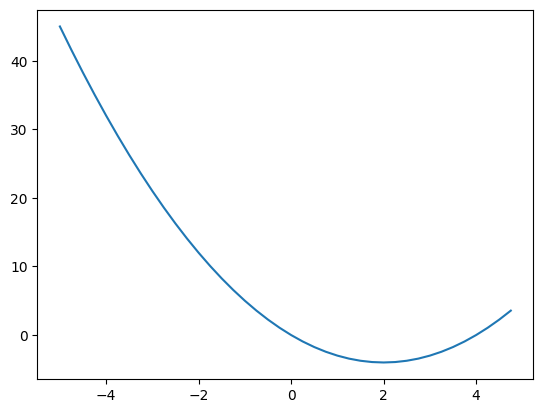

In [4]:
# Lets plot the function
plt.plot(xs, ys)

Lets introduce the concept of derivate:

```math
\frac{d}{dx} f(x) = \lim_{h \to 0} \frac{f(x+h)-f(x)}{h}
```

- x is the input value
- h is an infinitesimally small change in x (approaching zero)

The derivative represents the rate of change of the function at a given point, which can be thought of as the "instantaneous" speed at which the output changes when the input changes.

In simple terms, we increment the input x $f(x + h)$, then we compare it with the actual value $- f(x)$ and finally we normalice the change $/h$

In [5]:
# Lets compute the derivative of our function using the formula
h = 0.0000001 # Remember it tends to 0
x = 2/3
(f(x+h)-f(x))/h

-2.666666563122533

In [6]:
# We will declare a Value class, which will help us in the future determine which value changed
# the other value that made it change, and the operator of the change
class Value:
    def __init__(self, data, children=(), operator="", label = "") -> None:
        self.data = data
        self._prev = set(children)
        self._op = operator
        self.grad = 0.0
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    # Helper to ensure operands are of Value type
    def _ensure_value(self, other):
        return other if isinstance(other, Value) else Value(other)
    
    # Addition
    def __add__(self, other):
        other = self._ensure_value(other)
        return Value(self.data + other.data, children=(self, other), operator='+')

    def __radd__(self, other):
        # This is called when Value is on the right and int/float is on the left
        return self + other

    # Subtraction
    def __sub__(self, other):
        other = self._ensure_value(other)
        return Value(self.data - other.data, children=(self, other), operator='-')

    def __rsub__(self, other):
        # This is called when Value is on the right and int/float is on the left
        return Value(other) - self
    
    # Multiplication
    def __mul__(self, other):
        other = self._ensure_value(other)
        return Value(self.data * other.data, children=(self, other), operator='*')

    def __rmul__(self, other):
        # This is called when Value is on the right and int/float is on the left
        return self * other

    # Division
    def __truediv__(self, other):
        other = self._ensure_value(other)
        if other.data == 0:
            raise ZeroDivisionError("Cannot divide by zero")
        return Value(self.data / other.data, children=(self, other), operator='/')

    def __rtruediv__(self, other):
        # This is called when Value is on the right and int/float is on the left
        return Value(other) / self

    # Exponentiation
    def __pow__(self, other):
        other = self._ensure_value(other)
        return Value(self.data ** other.data, children=(self, other), operator='**')

    def __rpow__(self, other):
        # This is called when Value is on the right and int/float is on the left
        return Value(other) ** self
    
    # Hyperbolic Tangent (Tanh)
    def __tanh__(self):
        return Value((math.exp(self.data) - math.exp(-self.data)) / (math.exp(self.data) + math.exp(-self.data)), children=(self,), operator='tanh')



    
a = Value(2.0)
b = Value(-3.0)
a*b - a/b**2

Value(data=-6.222222222222222)

In [7]:
# Lets create a helper function for derivatives
def compute_derivative(x):
    h = Value(0.0000001)
    return (f(x+h) - f(x))/h

val = Value(-2.0)
compute_derivative(val)

Value(data=-7.999999898089527)

The 'gradient' is a multivariable generalization of the derivative. While a derivative can be defined only for single-variable functions, for functions of multiple variables, the gradient takes its place. The gradient is a vector-valued function, unlike a derivative, which is a scalar-valued function.

For example, if we have a function `f(x,y)` that depends on two variables `x` and `y`, the gradient would be:

$$\nabla f(x,y) = \left[\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}\right] 

 = \left[\frac{\partial f(x,y)}{\partial x}, \frac{\partial f(x,y)}{\partial y}\right]$$



The 'chain rule' is a formula that expresses the derivative of the composition of two differentiable functions.

$$\frac{dz}{dx} = \frac{dz}{dy}\cdot\frac{dy}{dx}$$


Backpropagation is a fundamental algorith that leverages the chain rule in order to calculate the gradients of a loss function with respect to a set of parameters (or NN weights). Later, they will be used to minimice this loss function and train the NN.

We will now create a function to draw nodes representing operations (or weigths) and manually backpropagete their respective gradients.

In [8]:
# Lets create a funtion to represent visualy backprop and gradients
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

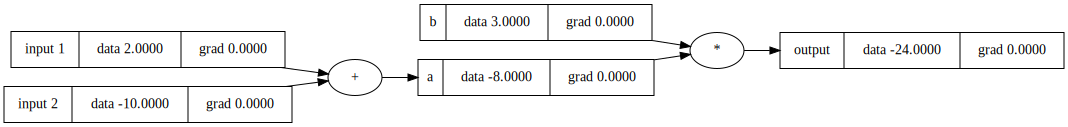

In [9]:
# Lets initialice our graph with default gradients
input_1 = Value(data=2.00, label="input 1")
input_2 = Value(data=-10.00, label="input 2")
a = input_1+input_2
a.label = "a"
b = Value(data=3.00, label="b")
output = a * b 
output.label="output"
draw_dot(output)

First case is simple:
$$\frac{dout}{da} = \frac{d(a*b)}{da} = b$$

Same thing for b:
$$\frac{dout}{db} = \frac{d(a*b)}{db} = a$$


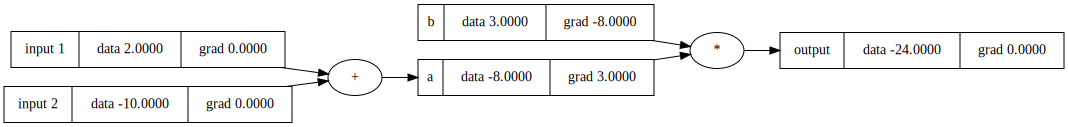

In [10]:
a.grad = b.data
b.grad = a.data
draw_dot(output)

Second node, we have to apply the chain rule case:
$$\frac{dout}{din1} = \frac{dout}{da}*\frac{da}{din1} = b*\frac{d(in1+in2)}{din1}=b*1$$

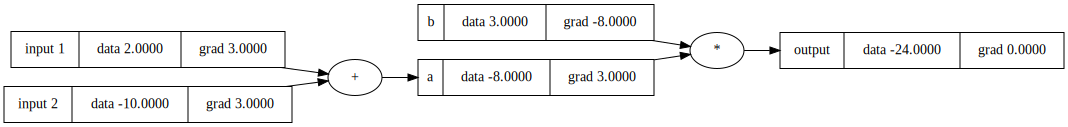

In [11]:
input_1.grad = b.data
input_2.grad = b.data
draw_dot(output)

The next step will be to dive into a single Neuron schema.

A neuron in a neural network receives multiple inputs, each associated with a weight $w_{k1} ,w_{k2} , …$ along with a bias term $b$. It first computes a weighted sum of the inputs and the bias, combining them linearly. After this, the neuron applies an activation function, which introduces non-linearity into the system. This non-linearity is crucial, as it allows the network to learn and model more complex patterns beyond simple linear relationships.

![My Image](../resources/neuron_schema.png "Image Description")


As the activation function, we will be using the hiperbolic tangent, which equals to:

$$\text{tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$


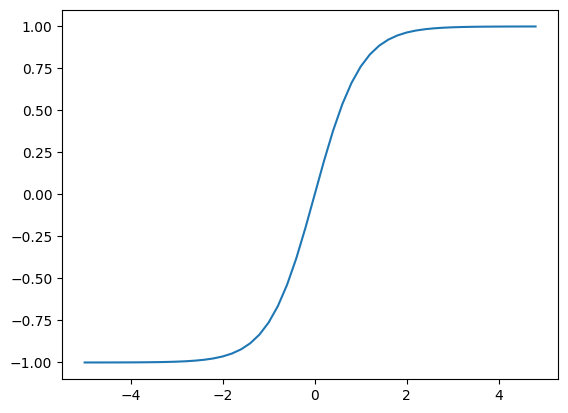

In [16]:
# Lets plot the tanh function
xs = np.arange(-5, 5, 0.2)
ys = np.tanh(xs)
plt.plot(xs, ys)